# Utility

In [322]:
import msgpack
import open3d as o3d
import trimesh
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

###########################################################
def NormalizeSignedDistance(signed_distance, zero_map_to=0.5):
    """
    Normalize to 0-1
    min-0 map to 0-0.5
    0-max map to 0.5-1
    """
    is_negative = signed_distance < 0

    normalized_distance = np.zeros_like(signed_distance)
    minimum = signed_distance.min()
    maximum = signed_distance.max()
    normalized_distance[is_negative] = (
        signed_distance[is_negative] - minimum) / np.abs(minimum) * zero_map_to
    normalized_distance[~is_negative] = zero_map_to + \
        signed_distance[~is_negative]/np.abs(maximum)*(1-zero_map_to)
    return normalized_distance


# https://matplotlib.org/tutorials/colors/colormaps.html
cmap = plt.cm.get_cmap('hot')

coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=60, origin=[0, 0, 0])


def rotate_view(vis):
    ctr = vis.get_view_control()
    ctr.rotate(3, 0.0)
    return False

In [323]:
########## discretization parameters ##############
radius_poisson = 6.5 # radius for the poisson sampling
radius_knn = radius_poisson*np.sqrt(3)*1.5
max_nn = 24 # maximun number of neighbors for a mass point

# Leg Discretization

In [324]:
import numpy as np
import matplotlib.pyplot as plt

#############################################
class Leg:
    def __init__(s, d0, d1, r0, r1, r2, r3, a0):
        s.d0 = d0  # length of first segment
        s.d1 = d1  # length of last segment
        s.r0 = r0  # radius of rotation of mid segment
        s.r1 = r1  # radius of the first segment
        s.r2 = r2  # radius at the end of second segment
        s.r3 = r3  # radius at the end of the last segment
        s.a0 = a0  # mid section rotation angle

        # the starting point of the last segment at centerline
        s.p1 = np.array((r0*np.sin(a0), r0*(1-np.cos(a0)), 0.))

        # unit vector
        s.ux = np.array((1., 0., 0.))
        s.uy = np.array((0., 1., 0.))
        s.uz = np.array((0., 0., 1.))

        # axis of rotation on the second segment
        s.pRot = np.array([0, r0, 0])

        s.angMidStart = -np.pi/2  # start angle of mid segment
        s.angMidEnd = -np.pi/2 + a0  # end angle of mid segment

        # centerline dirction (unit vector) of the last segment
        s.v1t = np.array((np.cos(a0), np.sin(a0), 0.))
        # normal of centerline dirction (unit vector) of the last segment
        s.v1n = np.array((-np.sin(a0), np.cos(a0), 0.))

        # vectorize the _CenterLineDirction function
        s.CenterLineDirction = np.vectorize(
            s._CenterLineDirction, signature='()->(n)', otypes=[float])

    def Idxs(s, t):
        idxs = np.empty((3, t.size), dtype=bool)
        # skip assertion for faster speed
        # beware t must be [-1,2]
        idxs[0] = t <= 0
        idxs[1] = np.logical_and(~idxs[0], t <= 1)
        idxs[2] = t > 1
        return idxs

    def _CenterLine(s, t):
        assert(-1 <= t <= 2)
        if t <= 0:
            return np.array((s.d0*t, 0., 0.))
        elif t <= 1:
            return np.array((s.r0*np.sin(s.a0*t), s.r0*(1.-np.cos(s.a0*t)), 0.))
        else:  # 1<=t<=2
            return s.p1+s.d1*(t-1.)*s.v1t

    def CenterLine(s, t, idxs=None):
        if (type(t) is not np.ndarray):
            return s._CenterLine(t)

        # cl: centerline ((x,y,z)...)
        cl = np.zeros((t.size, 3), dtype=float)
        if idxs is None:
            idxs = s.Idxs(t)
        cl[idxs[0], 0] = s.d0*t[idxs[0]]

        cl[idxs[1], 0] = s.r0*np.sin(s.a0*t[idxs[1]])
        cl[idxs[1], 1] = s.r0*(1.-np.cos(s.a0*t[idxs[1]]))

        cl[idxs[2]] = s.p1+s.d1*(t[idxs[2]]-1.)[:, None]*s.v1t[None, :]

        return cl

    def _CenterLineDirction(s, t):
        #         assert(-1 <= t <= 2)
        if t <= 0:
            return np.array((1, 0, 0))
        elif t <= 1:
            return np.array((r0*np.sin(s.a0*t), r0*(1.-np.cos(s.a0*t)), 0.))
        else:  # 1<=t<=2
            return s.v1t

    def _Radius(s, t):
        #         assert(-1 <= t <= 2)
        if t <= 0:
            return s.r1
        elif t <= 1:
            return s.r2*t+s.r1*(1.-t)
        else:  # 1<=t<=2
            return s.r3*(t-1)+s.r2*(2.-t)

    def Radius(s, t, idxs=None):
        if (type(t) is not np.ndarray):
            return s._Radius(t)
        r = np.empty_like(t, dtype=float)

        if idxs is None:
            idxs = s.Idxs(t)

        r[idxs[0]] = s.r1
        r[idxs[1]] = s.r1 + (s.r2-s.r1)*t[idxs[1]]
        r[idxs[2]] = 2*s.r2-s.r3 + (s.r3-s.r2)*t[idxs[2]]
        return r

    def _NormalDirction(s, t):
        #         assert(-1 <= t <= 2)
        if t <= 0:
            return s.uy
        elif t <= 1:
            return np.array((-np.sin(s.a0*t), np.cos(s.a0*t), 0.))
        else:  # 1<=t<=2
            return s.v1n

    def NormalDirction(s, t, idxs=None):
        if (type(t) is not np.ndarray):
            return s._NormalDirction(t)
        d = np.empty((t.size, 3), dtype=float)

        if idxs is None:
            idxs = s.Idxs(t)

        d[idxs[0]] = s.uy
        d[idxs[1], 0] = -np.sin(s.a0*t[idxs[1]])
        d[idxs[1], 1] = np.cos(s.a0*t[idxs[1]])
        d[idxs[1], 2] = 0.

        d[idxs[2]] = s.v1n
        return d

    def _SurfacePoint(s, t, w):
        return s._CenterLine(t) + s._Radius(t)*(
            s.uz*np.cos(w)+s._NormalDirction(t)*np.sin(w))

    def SurfacePoint(s, t, w):
        """
        calcualte the surface point given t and w, vectorized version of _SurfacePoint
        input:
            s: self
            t: variable [-1,2] that determines the location of the centerline
            w: variable [0,2pi] that determins the ange of the surface point, the 
                centerline and the z vector 
        """
        # t and w are both scaler
        if (type(t) is not np.ndarray) and (type(w) is not np.ndarray):
            return s._CenterLine(t) + s._Radius(t)*(
                s.uz*np.cos(w) + s._NormalDirction(t)*np.sin(w))
        else:
            if type(t) is not np.ndarray:
                t = np.array(t)
            if type(w) is not np.ndarray:
                w = np.array(w)

            # now t and w are both vectors
            return np.squeeze(s.CenterLine(t)[:, None, :] +
                              s.Radius(t)[:, None, None]*(
                s.NormalDirction(t)[:, None, :]*np.sin(w)[None, :, None] +
                s.uz[None, None, :]*np.cos(w)[None, :, None]))

    def RandomPoint(s, num, surfaceOnly=False):
        """
        generate random point within and on the body
        input:
            s: self
            num: number of random point to be generated
        """

        # length of the centerline
        len_centerline = s.d0+s.d1+s.r0*s.a0

        t_high = np.nextafter(2, 3)  # 2.0000000000000004

        t = np.hstack(
            (np.random.uniform(-1., 0, size=round(s.d0/len_centerline*num)),
             np.random.uniform(0, 1., size=round(
                 s.r0*s.a0/len_centerline*num)),
             np.random.uniform(1., t_high, size=round(s.d1/len_centerline*num))))

        num = t.size  # update the num

        idxs = s.Idxs(t)

#         t = np.random.uniform(low=-1, high=t_high, size=num)

        if surfaceOnly:
            r = s.Radius(t, idxs)
        else:
            # sqrt to accout for radius density is lower near the center
            r = s.Radius(t, idxs)*np.sqrt(
                np.random.uniform(0, np.nextafter(1, 2), size=num))

        w = np.random.uniform(low=-np.pi, high=np.pi, size=num)

        n = s.uz[None, :]*np.cos(w)[:, None] + \
            s.NormalDirction(t, idxs)*np.sin(w)[:, None]

        v = s.CenterLine(t) + r[:, None]*n
        return v, n

    def _PointIsInside(s, p, eps_r=1e-6,eps_t=1e-6):
        """
        input: a point p of np.array([x,y,z]) 
        returns:
            is_inside: (bool) ,true if p is inside or on the surface
            t: (float) a parameter that determins the position of the centerline point
            w: (float) angle of point p measured from the centerline
            r: (float) radius of point p measured from the centerline
        """

        # vector from the second section axis of rotation to the point
        v_p = p - s.pRot
        # element-wise arc tangent of y/x - s.angMidStart
        angle = np.arctan2(v_p[1], v_p[0]) - s.angMidStart
        is_inside = True

        if angle <= 0:
            # first segment
            t = p[0]/s.d0  # t parameter of the point

        elif angle <= s.a0:
            # mid segment
            t = angle/s.a0
        else:  # last segment
            # vector from the start of the last segment at centerline to point c
            v_p1p = p - s.p1
            # say pc is normal to centerline and intersect at c
            p1c = np.dot(v_p1p, s.v1t)
            t = 1 + p1c/s.d1

        c = s.CenterLine(t)  # point at centerline
        v_pc = p - c  # vector from centerline to point p
        r = np.linalg.norm(v_pc)
        v_n = s.NormalDirction(t)
        w = np.arctan2(np.dot(v_pc, v_n), v_pc[2])

        if r > s.Radius(t)+eps_r or t < -1-eps_t or t > 2+eps_t:
            is_inside = False

        return is_inside, t, w, r

    def PointIsInside(s, p, eps_r=1e-6,eps_t=1e-6):
        """
        input: point p of np.array([x,y,z]) 
                or np.array([[x0,y0,z0],[x1,y1,z1],...]) 

        returns:
            is_inside: (bool) or np.array(bool),true if p is inside or on the surface
            t: (float) or np.array(float) a parameter that determins the position of the centerline point
            w: (float) or np.array(float) angle of point p measured from the centerline
            r: (float) or np.array(float) radius of point p measured from the centerline
        """
        if type(p) is not np.ndarray:
            p = np.asarray(p)
        if p.shape == (3,):
            return s._PointIsInside(p,eps_r,eps_t)

        # vector from the second section axis of rotation to the point
        v_p = p - s.pRot
        # element-wise arc tangent of y/x - s.angMidStart
        angle = np.arctan2(v_p[:, 1], v_p[:, 0]) - s.angMidStart

        num_points = p.shape[0]
        idxs = np.empty((3, num_points), dtype=bool)
        # skip assertion for faster speed
        # beware t must be [-1,2]
        idxs[0] = angle <= 0  # first segment
        idxs[1] = np.logical_and(angle > 0, angle <= s.a0)  # mid segment
        idxs[2] = angle > s.a0  # last segment

        is_inside = np.ones(num_points, dtype=bool)
        t = np.empty(num_points, dtype=float)

        t[idxs[0]] = p[idxs[0], 0]/s.d0  # t at first segment
        t[idxs[1]] = angle[idxs[1]]/s.a0  # t at mid segment

        # vector from the start of the last segment at centerline to point c
        v_p1p = p[idxs[2]] - s.p1
        # say pc is normal to centerline and intersect at c
        p1c = np.dot(v_p1p, s.v1t)
        t[idxs[2]] = 1 + p1c/s.d1

        c = s.CenterLine(t)  # points at centerline
        v_pc = p - c  # vector from centerline to point p
        r = np.linalg.norm(v_pc, axis=1)
        v_n = s.NormalDirction(t)

        # w = np.arctan2(np.dot(v_pc, v_n), v_pc[:,2]) # scalar versin
        # einsum is the row wise dot product
        w = np.arctan2(np.einsum('ij,ij->i', v_pc, v_n), v_pc[:, 2])

        is_inside[np.logical_or(
            np.logical_or(r > s.Radius(t)+eps_r, t < -1-eps_t), t > 2+eps_t)] = False
#         if r > s.Radius(t)+s.eps or t < -1-s.eps or t > 2+s.eps:
#             is_inside = False

        return is_inside, t, w, r

    def GetBounds(s):
        v_pf, n_pf = s.RandomPoint(50000, surfaceOnly=True)

        bounds = np.asarray((v_pf.min(axis=0), v_pf.max(axis=0)))
        greater0 = bounds > 0
        less0 = bounds < 0
        bounds[greater0] = np.ceil(bounds[greater0])
        bounds[less0] = np.floor(bounds[less0])
        return bounds

In [325]:
joint_overlap_radius = 10
joint_overlap = joint_overlap_radius*2
leg_d0 = 20

leg = Leg(d0=leg_d0+joint_overlap, d1=50, r0=30, r1=20, r2=16,  r3=10, a0=np.pi*3/5)

len_centerline = leg.d0+leg.d1+leg.r0*leg.a0

num_t = 180
# t_space
t_space = np.hstack(
    (np.linspace(-1., 0, num=round(leg.d0/len_centerline*num_t)),
     np.linspace(0, 1., num=round(leg.r0*leg.a0/len_centerline*num_t)),
     np.linspace(1., 2., num=round(leg.d1/len_centerline*num_t))))

# w_space
w_space = np.linspace(0, 2*np.pi, num=720, endpoint=False)


#### unit test
np.alltrue(leg.PointIsInside([
    leg.SurfacePoint(-0.5, -np.pi/3),
    leg.SurfacePoint(0.5, -np.pi/3),
    leg.SurfacePoint(1.5, -np.pi/3)])[0])
####

# surface_points = leg.SurfacePoint(t_space,w_space).reshape((-1,3))

#######################################
# v_leg: nx3 np array of vertices
# n_leg: nx3 np array of vertex normals
v_leg, n_leg = leg.RandomPoint(1500000)
v_leg_f, n_leg_f = leg.RandomPoint(100000, surfaceOnly=True)

center_line = leg.CenterLine(t_space)
radius = leg.Radius(t_space)
normal = leg.NormalDirction(t_space)

In [4]:
# fig, axes = plt.subplots(1,3,dpi=100,figsize=(8,4))

# axes[0].plot(center_line[:,0],center_line[:,1])
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('center line')
# plt.axis('equal')

# axes[1].plot(t_space,radius)
# plt.xlabel('t')
# plt.ylabel('radius')
# plt.title('radius')

# axes[2].quiver(center_line[::3,0],center_line[::3,1],normal[::3,0],normal[::3,1])
# plt.axis('equal')
# plt.xlabel('t')
# plt.ylabel('radius')
# plt.title('radius')
# plt.tight_layout()
# plt.show()

In [5]:
# # Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
# pcd_leg = o3d.geometry.PointCloud()
# pcd_leg.points = o3d.utility.Vector3dVector(np.vstack((v_leg_f, v_leg)))
# # pcd_leg.points = o3d.utility.Vector3dVector(np.round(np.vstack((v_leg_f,v_leg))))

# pcd_leg_centerline = o3d.geometry.PointCloud()
# pcd_leg_centerline.points = o3d.utility.Vector3dVector(center_line)
# pcd_leg_centerline.paint_uniform_color([1, 0, 0])

# pcd_leg_surface = o3d.geometry.PointCloud()
# pcd_leg_surface.points = o3d.utility.Vector3dVector(
#     np.vstack((v_leg_f, center_line)))

# # # visualization
# # # o3d.visualization.draw_geometries([pcd_leg,coord_frame])
# # o3d.visualization.draw_geometries_with_animation_callback([pcd_leg],rotate_view)
# # o3d.visualization.draw_geometries([pcd_leg_surface,coord_frame])
# # # o3d.visualization.draw_geometries_with_animation_callback([pcd_leg_centerline,pcd_leg_surface,coord_frame],
# # #                                                               rotate_view)

In [326]:
# downsampling
import point_cloud_utils as pcu

# v_leg_down, n_leg_down = pcu.prune_point_cloud_poisson_disk(
#     v=v_leg, n=n_leg, radius=radius_poisson, best_choice_sampling=False)
# print(v_leg_down.shape)
# pcd_leg_d = o3d.geometry.PointCloud()  # down-sampled point cloud data
# pcd_leg_d.points = o3d.utility.Vector3dVector(v_leg_down)
# # o3d.visualization.draw_geometries([pcd_leg_d,coord_frame])

from joblib import Parallel, delayed
def SamplingHelper(radius_poisson,num_points = 150000):
    v_leg, n_leg = leg.RandomPoint(num_points)
    v_leg_down, n_leg_down = pcu.prune_point_cloud_poisson_disk(
    v=v_leg, n=n_leg, radius=radius_poisson, best_choice_sampling=True)
    return v_leg_down

n_jobs = int(multiprocessing.cpu_count()*0.95)
result = Parallel(n_jobs=n_jobs)(delayed(SamplingHelper)(radius_poisson) for i in range(n_jobs))
# find the leg that has the least deviation from the centerline in the first section
mse_list = [np.linalg.norm(np.mean(v_down[v_down[:,0]<=0],axis=0)[1:]) for v_down in result]
v_leg_down = result[np.argmin(mse_list)]

pcd_leg_d = o3d.geometry.PointCloud()  # down-sampled point cloud data
pcd_leg_d.points = o3d.utility.Vector3dVector(v_leg_down)
# o3d.visualization.draw_geometries([pcd_leg_d,coord_frame])

#mass: 463
#springs: 5257
COM at 1st section: [-20.655   0.025  -0.052]
COM: [ 6.776 18.457 -0.103]
mean neighbors =23.7


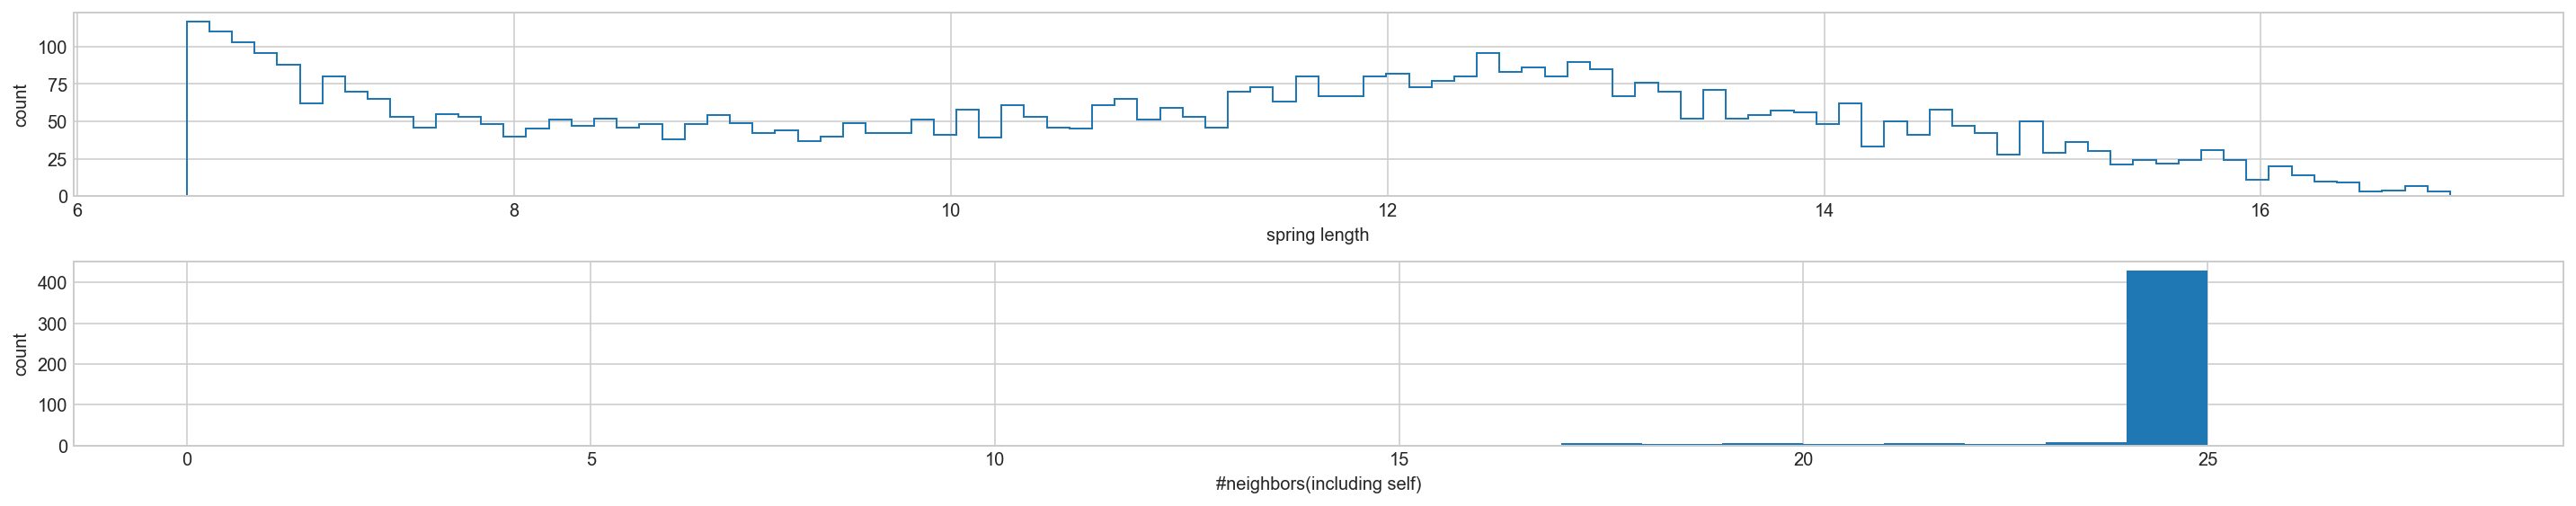

In [327]:
# KDTree for nearest neighbor search
pcd_leg_tree = o3d.geometry.KDTreeFlann(pcd_leg_d)

# o3d.visualization.draw_geometries([pcd_leg_d,coord_frame])

neighbors = [np.asarray(pcd_leg_tree.search_hybrid_vector_3d(point, radius_knn,max_nn = max_nn)[1]) for point in v_leg_down]

def GetEdges(neighbor):
    candidate = neighbor[1:]
    self = neighbor[0]
    candidate = candidate[candidate<self] # to remove redundency
    edges = np.empty((candidate.size,2),dtype=np.int32)
    edges[:,0]=self
    edges[:,1]=candidate
    return edges

lines_leg = np.vstack([GetEdges(neighbor) for neighbor in neighbors])

print("#mass: %i"%v_leg_down.shape[0])
print("#springs: %i"%lines_leg.shape[0])

lsd_leg = o3d.geometry.LineSet()
lsd_leg.points = o3d.utility.Vector3dVector(v_leg_down)
lsd_leg.lines = o3d.utility.Vector2iVector(lines_leg)
with np.printoptions(precision=3, suppress=True):
    print("COM at 1st section:",np.mean(v_leg_down[v_leg_down[:,0]<=0],axis=0))
    print("COM:",np.mean(v_leg_down,axis=0))

    
fig, ax = plt.subplots(2,1,figsize=(20,4))

# check the distribution of the distance of the springs
ax[0].hist(np.linalg.norm(v_leg_down[lines_leg[:,0]] - v_leg_down[lines_leg[:,1]],axis=1),bins=100,histtype="step")
ax[0].set_xlabel("spring length")
ax[0].set_ylabel("count")
# check the #of neighbors
neighbor_counts = np.array([len(neighbor) for neighbor in neighbors])
print(f"mean neighbors ={np.mean(neighbor_counts):.1f}")
hist,bin_edges,patches =ax[1].hist(neighbor_counts,bins=28,range=(0,28))
ax[1].set_xlabel("#neighbors(including self)")
ax[1].set_ylabel("count")

plt.tight_layout()
plt.show()

In [328]:
# color the pointcloud and lines
cmap = plt.cm.get_cmap('hot')

_,t,_,r=leg.PointIsInside(v_leg_down)
signed_distance = leg.Radius(t)-r

colors = cmap(NormalizeSignedDistance(signed_distance,zero_map_to=0.))[:,:3] # drop alpha channel
# colors[neighbor_counts<25]=(0,1,1)

pcd_leg_d.colors = o3d.utility.Vector3dVector(colors)
# the line colors are the average of the two end points colors
leg_lines_colors = (colors[lines_leg[:,0]]+colors[lines_leg[:,1]])/2
lsd_leg.colors = o3d.utility.Vector3dVector(leg_lines_colors)

In [329]:
o3d.visualization.draw_geometries([lsd_leg, pcd_leg_d,coord_frame])

# o3d.visualization.draw_geometries([pcd_leg])
# o3d.visualization.draw_geometries([pcd_leg_d])
# o3d.visualization.draw_geometries_with_animation_callback([lsd_leg,coord_frame,pcd_leg_d],rotate_view)
# o3d.visualization.draw_geometries_with_animation_callback([lsd_leg,coord_frame,pcd_leg_d,pcd_leg_centerline],rotate_view,
#                                                          width=1080, height=1080)

# Body discretization

In [330]:
from numba import jit
@jit("float64[:,:](float64[:,:], float64,int64)",nopython=True)
def UniformRandomAroundPoints(points,radius,num_per_grid=50):
    num_grid = points.shape[0]
    xyz = np.empty((num_grid*num_per_grid,3),dtype=np.float64)
#     for i,point in enumerate(points):
    for i in range(num_grid):
        point = points[i]
        start = num_per_grid*i
        end = start+num_per_grid
        xyz[start:end,0] = np.random.uniform(point[0]-radius,point[0]+radius,num_per_grid)
        xyz[start:end,1] = np.random.uniform(point[1]-radius,point[1]+radius,num_per_grid)
        xyz[start:end,2] = np.random.uniform(point[2]-radius,point[2]+radius,num_per_grid)
    return xyz

In [331]:
# %load_ext line_profiler
import numpy as np
import trimesh
mesh_body = trimesh.load("../mesh/mainbody_v2_simplified.stl", use_embree=True)
mesh_body_filled = trimesh.load("../mesh/mainbody_v2_simplified_filled.stl", use_embree=True)

#####

# radius_grid = radius_poisson/np.sqrt(3)
radius_grid = radius_poisson/2.5

bounds = mesh_body.bounds

# convert to integer, type is still float
bounds = np.stack((np.floor(bounds[0]), np.ceil(bounds[1])))
print("bounds=\n", bounds)


nx = int(np.ceil((bounds[1, 0]-bounds[0, 0])/radius_grid))
ny = int(np.ceil((bounds[1, 1]-bounds[0, 1])/radius_grid))
nz = int(np.ceil((bounds[1, 2]-bounds[0, 2])/radius_grid))

x = np.linspace(bounds[0, 0], bounds[0, 0]+nx*radius_grid, num=nx+1)
y = np.linspace(bounds[0, 1], bounds[0, 1]+ny*radius_grid, num=ny+1)
z = np.linspace(bounds[0, 2], bounds[0, 2]+nz*radius_grid, num=nz+1)

xyz_grid = np.stack(np.meshgrid(x, y, z), axis=-1)
xyz_grid_flat = xyz_grid.reshape((-1, 3))

grid_is_inside_flat = mesh_body.ray.contains_points(xyz_grid_flat)
grid_is_inside = grid_is_inside_flat.reshape(xyz_grid.shape[:-1])

print(f"xyz_grid.shape={xyz_grid.shape}")


############################################
from scipy.ndimage.morphology import binary_dilation, binary_erosion

window = np.ones((3, 3, 3))

grid_is_edge = binary_dilation(
    grid_is_inside, window)*~binary_erosion(grid_is_inside, window)

# grid_is_edge = binary_dilation(
#     grid_is_inside)*~binary_erosion(grid_is_inside)
print(f"{grid_is_edge.sum()}")

grid_is_deep_inside = grid_is_inside*~grid_is_edge
# grid_is_deep_inside.sum()

##############################

bounds=
 [[ -74.  -26. -115.]
 [  74.   26.  115.]]
xyz_grid.shape=(21, 58, 90, 3)
37924


In [332]:
xyz_is_edge_candidate = UniformRandomAroundPoints(xyz_grid[grid_is_edge],
                                                  radius_grid,num_per_grid=30)
xyz_deep_inside_candidate = UniformRandomAroundPoints(xyz_grid[grid_is_deep_inside],
                                                      radius_grid,num_per_grid=30)

is_edge_candidate = mesh_body.ray.contains_points(xyz_is_edge_candidate)
xyz_edge_candidate = xyz_is_edge_candidate[is_edge_candidate]

# pcd_body = o3d.geometry.PointCloud()
# pcd_body.points = o3d.utility.Vector3dVector(xyz_edge_candidate)
# o3d.visualization.draw_geometries([pcd_body,coord_frame])

print(xyz_deep_inside_candidate.shape)
print(xyz_is_edge_candidate.shape)

(384750, 3)
(1137720, 3)


In [281]:
# pcd_body = o3d.geometry.PointCloud()
# pcd_body.points = o3d.utility.Vector3dVector(xyz_grid[grid_is_deep_inside])
# o3d.visualization.draw_geometries([pcd_body,coord_frame])

# pcd_body = o3d.geometry.PointCloud()
# pcd_body.points = o3d.utility.Vector3dVector(xyz_grid[grid_is_inside])
# o3d.visualization.draw_geometries([pcd_body,coord_frame])

# pcd_body = o3d.geometry.PointCloud()
# pcd_body.points = o3d.utility.Vector3dVector(xyz_grid[grid_is_edge])
# o3d.visualization.draw_geometries([pcd_body,coord_frame])

In [333]:
import point_cloud_utils as pcu
xyz_candidate = np.vstack([xyz_deep_inside_candidate, xyz_edge_candidate])
# poisson disk down sampling
# down-sampled point cloud data
xyz_body, _ = pcu.prune_point_cloud_poisson_disk(v=xyz_candidate, n=np.ones_like(
    xyz_candidate), radius=radius_poisson, best_choice_sampling=True)
print(xyz_body.shape)

pcd_body = o3d.geometry.PointCloud()
pcd_body.points = o3d.utility.Vector3dVector(xyz_body)
# o3d.visualization.draw_geometries([pcd_body, coord_frame])
# o3d.visualization.draw_geometries_with_animation_callback([pcd_body,coord_frame],rotate_view)

(2275, 3)


In [290]:
# pcd_body = o3d.geometry.PointCloud()
# pcd_body.points = o3d.utility.Vector3dVector(xyz_candidate)
# o3d.visualization.draw_geometries([pcd_body,coord_frame])

#mass: 2275
#springs: 25915
COM: [ 0.097 -0.005  2.123]
mean neighbors =23.8


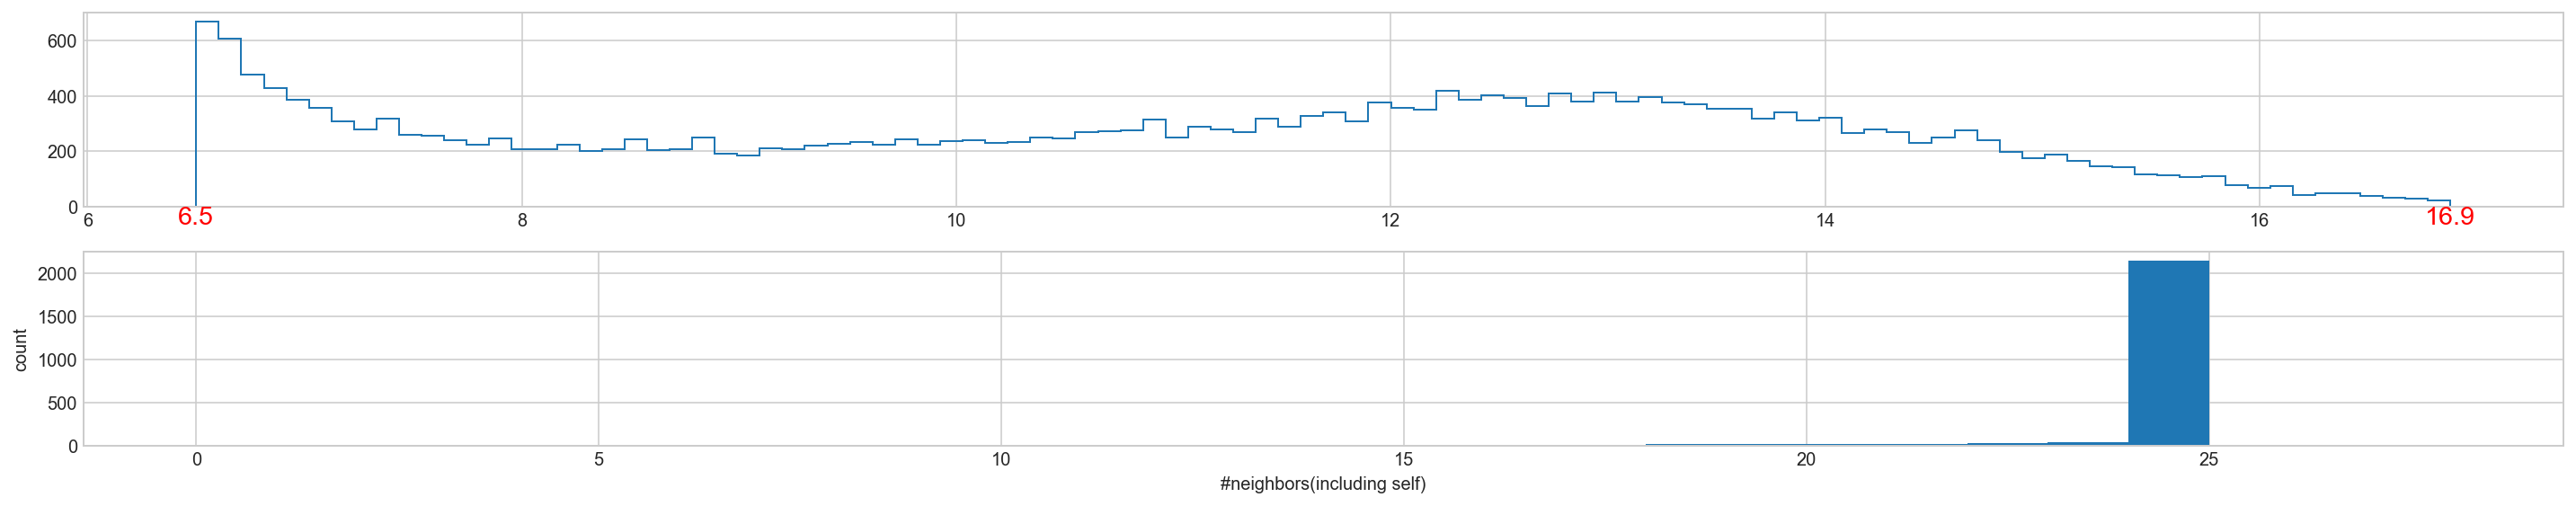

In [334]:
pcd_tree = o3d.geometry.KDTreeFlann(pcd_body)

# o3d.visualization.draw_geometries([pcd_d,coord_frame])

# max_nn = 18

# [k, idx, _] = pcd_tree.search_radius_vector_3d(pcd_d.points[0], radius*np.sqrt(3)+0.1)
# neighbors = [np.asarray(pcd_tree.search_radius_vector_3d(point, radius*(np.sqrt(3)+0.01))[1]) for point in xyz_body]
neighbors = [np.asarray(pcd_tree.search_hybrid_vector_3d(
    point, radius_knn, max_nn=max_nn)[1]) for point in xyz_body]


def GetEdges(neighbor):
    candidate = neighbor[1:]
    self = neighbor[0]
    candidate = candidate[candidate < self]  # to remove redundency
    edges = np.empty((candidate.size, 2), dtype=np.int32)
    edges[:, 0] = self
    edges[:, 1] = candidate
    return edges


lines_body = np.vstack([GetEdges(neighbor) for neighbor in neighbors])

print("#mass: %i" % xyz_body.shape[0])
print("#springs: %i" % lines_body.shape[0])

lsd_body = o3d.geometry.LineSet()
lsd_body.points = o3d.utility.Vector3dVector(xyz_body)
lsd_body.lines = o3d.utility.Vector2iVector(lines_body)

# lsd_body.paint_uniform_color((0.1,0.1,0.1))
with np.printoptions(precision=3, suppress=True):
    print("COM:", np.mean(xyz_body, axis=0))

# plottig the distribution of the lenght of springs
fig, ax = plt.subplots(2,1,figsize=(20,4))
hist,bin_edges,_ = ax[0].hist(np.linalg.norm(xyz_body[lines_body[:,0]] - xyz_body[lines_body[:,1]],axis=1),bins=100,histtype="step")
ax[0].text(bin_edges[0],0,f"{bin_edges[0]:.1f}",ha="center",va="top",fontsize="x-large",color='r')
ax[0].text(bin_edges[-1],0,f"{bin_edges[-1]:.1f}",ha="center",va="top",fontsize="x-large",color='r')


# check the #of neighbors
neighbor_counts = np.array([len(neighbor) for neighbor in neighbors])
print(f"mean neighbors ={np.mean(neighbor_counts):.1f}")
hist,bin_edges,patches =ax[1].hist(neighbor_counts,bins=28,range=(0,28))
ax[1].set_xlabel("#neighbors(including self)")
ax[1].set_ylabel("count")
plt.tight_layout()
plt.show()

In [335]:
# colorize the body
signed_distance = trimesh.proximity.signed_distance(mesh_body,xyz_body)

cmap = plt.cm.get_cmap('hot')
colors = cmap(NormalizeSignedDistance(signed_distance,zero_map_to=0.))[:,:3] # drop alpha channel
pcd_body.colors = o3d.utility.Vector3dVector(colors)

body_lines_colors = (colors[lines_body[:,0]]+colors[lines_body[:,1]])/2
lsd_body.colors = o3d.utility.Vector3dVector(body_lines_colors)

In [336]:
o3d.visualization.draw_geometries([pcd_body,lsd_body])

# o3d.visualization.draw_geometries_with_animation_callback([lsd_body,coord_frame,pcd_d],rotate_view)
# o3d.visualization.draw_geometries_with_animation_callback([lsd_body,coord_frame,pcd_body],rotate_view,
#                                                          width=1920, height=1080)

# Assemble the parts

In [337]:
from scipy.spatial.transform import Rotation as R
def RotateFromVec(vec, angle):
    vec = np.asarray(vec, dtype=np.float64)
    vec_norm = np.linalg.norm(vec)
    if vec_norm != 1:
        vec = vec/vec_norm
    vec *= angle
    h = np.eye(4)
    h[:3, :3] = R.from_rotvec(vec).as_dcm()
    return h


def Translate(vec, h=None):
    if h is None:
        h = np.eye(4)
    h[:3, -1] += vec
    return h

def ApplyTransform(xyz, t):
    """
    apply transform t to xyz, !!Note that t is transposed!!!
    if transform.shape=(3,3): rotation
    if transform.shape=(4,4): homogegenious transformation (rotation+translation)
    """
    xyz = np.asarray(xyz)
    if t.shape == (3,3): # rotation matrix
        return np.dot(xyz, t.T)
    elif t.shape ==(4,4): # homogeneous matrix
        return np.dot(xyz, t[:-1, :-1].T)+t[:-1, -1]
    else:
        raise AssertionError("dimension error")

In [338]:
dx_front = 20
dx_back = 11
dy = 75
rot_ang = 25
cylinder_len = 49.5

t_axial = Translate((0,0,cylinder_len-joint_overlap_radius)) # translate along cylinder

t_zrot = RotateFromVec((0,0,1),np.pi)

t0 = Translate((dx_front,0,dy)).dot(RotateFromVec((0, 1, 0),(90-rot_ang)/180.*np.pi).dot(t_axial))# front left
t1 = Translate((dx_back,0,-dy)).dot(RotateFromVec((0, 1, 0),(90+rot_ang)/180.*np.pi).dot(t_axial))# back left
t2 = Translate((-dx_front,0,dy)).dot(RotateFromVec((0, 1, 0),(-90+rot_ang)/180.*np.pi).dot(t_zrot).dot(t_axial))# front right
t3 = Translate((-dx_back,0,-dy)).dot(RotateFromVec((0, 1, 0),(-90-rot_ang)/180.*np.pi).dot(t_zrot).dot(t_axial))# back right
# t2 = Translate((-dx_front,0,dy)).dot(RotateFromVec((0, 1, 0),(-90+rot_ang)/180.*np.pi).dot(t_axial))# front right
# t3 = Translate((-dx_back,0,-dy)).dot(RotateFromVec((0, 1, 0),(-90-rot_ang)/180.*np.pi).dot(t_axial))# back right
# t_leg_alignment = np.array([
#     [0,0,1,0],
#     [1,0,0,0],
#     [0,1,0,0],
#     [0,0,0,1]],dtype=np.float64)
leg_axes_transform = [t0,t1,t2,t3]

t_leg_alignment =Translate((0,0,leg_d0+joint_overlap_radius),np.dot(RotateFromVec((0,0,1),np.pi/2),RotateFromVec((0,1,0),-np.pi/2)))

leg_transform = [np.dot(t,t_leg_alignment) for t in leg_axes_transform]

In [339]:
# cylinders for getting the rotation anchor points on the body
cylinders = [
    trimesh.creation.cylinder(radius=30, height=joint_overlap, transform=t0),
    trimesh.creation.cylinder(radius=30, height=joint_overlap, transform=t1),
    trimesh.creation.cylinder(radius=30, height=joint_overlap, transform=t2),
    trimesh.creation.cylinder(radius=30, height=joint_overlap, transform=t3)] # 20 will be covered

# axis_size=5
# axis_origin_tri = trimesh.creation.axis(axis_size*2)
# # front left, back left, front right, back right
# axes = [trimesh.creation.axis(axis_size,transform=t) for t in leg_axes_transform]
# # mesh_body.visual.face_colors=np.array((102, 102, 102, 1))
# scene=trimesh.scene.Scene(geometry=axes+[axis_origin_tri,mesh_body]+cylinders)
# scene.show()

In [340]:
axes = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=60, origin=[0, 0, 0]).transform(t) for t in leg_axes_transform]

legs = [o3d.geometry.PointCloud(pcd_leg_d).transform(t) for t in leg_transform]
lsd_legs = [o3d.geometry.LineSet(lsd_leg).transform(t) for t in leg_transform]



print("#springs =%i"%(len(lsd_leg.lines)*4+len(lsd_body.lines)))
print("#mass =%i"%(len(pcd_leg_d.points)*4+len(pcd_body.points)))

#springs =46943
#mass =4127


In [341]:
o3d.visualization.draw_geometries([pcd_body]+axes+legs)
# o3d.visualization.draw_geometries(axes+legs)
# o3d.visualization.draw_geometries([pcd_body]+axes)
# o3d.visualization.draw_geometries([pcd_body,lsd_body]+legs+lsd_legs+axes)
# o3d.visualization.draw_geometries_with_animation_callback([pcd_body,lsd_body]+legs+lsd_legs,rotate_view)
# o3d.visualization.draw_geometries([pcd_body]+axes+legs)

In [342]:
# # axes_all = [axis_body, axis_leg0, axis_leg1, axis_leg2, axis_leg3]
# axes_all = [coord_frame] + axes

# pcd list of parts
pcd_parts = [pcd_body]+legs 

# lst list of parts
lsd_parts = [lsd_body]+lsd_legs

# transform_all = [transform_body, transform_leg0, transform_leg1, transform_leg2, transform_leg3]
transform_all = [np.eye(4)] + leg_axes_transform

# list of boolean array for the rotation ids of the body, 4 in total
body_rot_ids = [cylinder.ray.contains_points(xyz_body) for cylinder in cylinders]

# list of np boolean array indicating if point is part of rotational jonit
leg_rot_ids = [np.asarray(pcd_leg_d.points)[:,0]<-leg_d0]*len(legs)

# xyzs of the components [body,leg,leg,leg,leg]
xyz_parts = [np.asarray(pcd.points) for pcd in pcd_parts]

# the edges of the points start and end index for each part of the component
id_xyz_parts_edges = np.cumsum([0]+[len(xyz) for xyz in xyz_parts])
print(f"id_xyz_parts_edges={id_xyz_parts_edges}")

# lines of the components [body,leg,leg,leg,leg]
lines_parts = [np.asanyarray(lsd.lines) for lsd in lsd_parts]

id_lines_parts_edges = np.cumsum([0]+[len(lines) for lines in lines_parts])
print(f"id_lines_parts_edges={id_lines_parts_edges}")


n_parts = len(xyz_parts) # number of components
print(f"n_parts={n_parts}")
n_joints = len(legs)
print(f"n_joints={n_joints}")

# array of index of the componet for a joint
id_joint_components = np.array([[0,1],[0,2],[0,3],[0,4]])

# list of transform for each joint
joint_transforms = leg_axes_transform

# the actual points (bool array)
joint_tuples = list(zip(body_rot_ids,leg_rot_ids))

# rot_anchor_radius = joint_overlap_radius+radius_poisson
rot_anchor_radius = 20
print(f"rot_anchor_radius={rot_anchor_radius}")

# anchor points for each of the rotational joint
rot_anchors = [ApplyTransform([[0,0,-rot_anchor_radius],
                               [0,0,rot_anchor_radius]],t) 
               for t in leg_axes_transform]
# print(rot_anchors)

# create pointcloud for anchors
pcd_anchors = o3d.geometry.PointCloud()
pcd_anchors.points = o3d.utility.Vector3dVector(np.vstack(rot_anchors))
pcd_anchors.colors = o3d.utility.Vector3dVector(np.tile((1.,0,0), (len(pcd_anchors.points), 1)))

id_xyz_parts_edges=[   0 2275 2738 3201 3664 4127]
id_lines_parts_edges=[    0 25915 31172 36429 41686 46943]
n_parts=5
n_joints=4
rot_anchor_radius=20


In [343]:
id_joint_components

array([[0, 1],
       [0, 2],
       [0, 3],
       [0, 4]])

In [344]:
def GetCoordinateOXYZ(transform):
    coordinate_radius = 16
    o = transform[:3,-1] # origin
    x = o + coordinate_radius * transform[:3,0]
    y = o + coordinate_radius * transform[:3,1]
    z = o + coordinate_radius * transform[:3,2]
    oxyz = np.vstack([o,x,y,z])
    return oxyz

class Coord:# coordinate
    def __init__(s, body_id, transform):
        """
        body_id: body index,e.g. mainbody=0,leg0=1,leg1=2,leg2=3,leg3=4
        transform: 4x4 numpy transform matrix
        """
        s.bodyId = body_id
        s.transform = transform
        s.oxyz = GetCoordinateOXYZ(transform)
        # index offset for the coordinate
        s.id_start = id_xyz_parts_edges[body_id]


coord_list = [
    Coord(0, transform_all[0]),# body axis
    Coord(id_joint_components[0,0],joint_transforms[0]), # joint0-body axis
    Coord(id_joint_components[0,1],joint_transforms[0]), # joint0-leg0 axis
    Coord(id_joint_components[1,0],joint_transforms[1]), # joint1-body axis
    Coord(id_joint_components[1,1],joint_transforms[1]), # joint1-leg1 axis
    Coord(id_joint_components[2,0],joint_transforms[2]), # joint2-body axis
    Coord(id_joint_components[2,1],joint_transforms[2]), # joint2-leg2 axis
    Coord(id_joint_components[3,0],joint_transforms[3]), # joint3-body axis
    Coord(id_joint_components[3,1],joint_transforms[3])  # joint3-leg3 axis
]

# oxyzs: list of oxyz from coord_list
oxyzs = [c.oxyz for c in coord_list]

# pcd of oxyzs
pcd_oxyzs = o3d.geometry.PointCloud()
pcd_oxyzs.points = o3d.utility.Vector3dVector(np.vstack(oxyzs))
pcd_oxyzs.colors = o3d.utility.Vector3dVector(np.tile((1.,0,0), (len(pcd_oxyzs.points), 1)))
# o3d.visualization.draw_geometries([pcd_oxyzs])

In [345]:
# get all colors
pcds = [pcd_body]+legs+[pcd_anchors]+[pcd_oxyzs]
colors_all = np.vstack(list(map(np.asarray,[pcd.colors for pcd in pcds])))

# the acutal points list, arrange as
# [xyz_0,xyz_1,...,xyz_n,]+ [xyz_anchor_0,...,xyz_anchor_m] + [oxyz_0,oxyz_1,..]
xyzs = xyz_parts + rot_anchors + oxyzs

xyz_all = np.vstack(xyzs)

# the count of points in each component of xyzs
points_counts = [len(xyz) for xyz in xyzs]
print(f"points_counts={points_counts}")


# the edges of the points start and end index for each part of the component
# e.g. the idex of xyzs[k] start at id_xyzs_edges[k], and ends at id_xyzs_edges[k+1]
# the rot_anchors [j] start at id_xyzs_edges[n_parts+k], and ends at id_xyzs_edges[n_parts+k+1]
id_xyzs_edges = np.cumsum([0]+[len(xyz) for xyz in xyzs])
print(f"id_xyzs_edges={id_xyzs_edges}")
list(zip(id_xyzs_edges,"body,leg0,leg1,leg2,leg3,anchor0,anchor1,anchor2,anchor3,oxyz_body,\
oxyz_joint0_body,oxyz_joint0_leg0,oxyz_joint1_body,oxyz_joint1_leg1,\
oxyz_joint2_body,oxyz_joint2_leg2,oxyz_joint3_body,oxyz_joint3_leg3,\
the end".split(",")))

points_counts=[2275, 463, 463, 463, 463, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4]
id_xyzs_edges=[   0 2275 2738 3201 3664 4127 4129 4131 4133 4135 4139 4143 4147 4151
 4155 4159 4163 4167 4171]


[(0, 'body'),
 (2275, 'leg0'),
 (2738, 'leg1'),
 (3201, 'leg2'),
 (3664, 'leg3'),
 (4127, 'anchor0'),
 (4129, 'anchor1'),
 (4131, 'anchor2'),
 (4133, 'anchor3'),
 (4135, 'oxyz_body'),
 (4139, 'oxyz_joint0_body'),
 (4143, 'oxyz_joint0_leg0'),
 (4147, 'oxyz_joint1_body'),
 (4151, 'oxyz_joint1_leg1'),
 (4155, 'oxyz_joint2_body'),
 (4159, 'oxyz_joint2_leg2'),
 (4163, 'oxyz_joint3_body'),
 (4167, 'oxyz_joint3_leg3'),
 (4171, 'the end')]

In [346]:
id_xyzs_anchor_start = id_xyzs_edges[n_parts]
print(f"id_xyzs_anchor_start={id_xyzs_anchor_start}")

id_xyzs_oxyz_start = id_xyzs_edges[n_parts+n_joints]
print(f"id_xyzs_oxyz_start={id_xyzs_oxyz_start}")

id_xyzs_joint_oxyz_start = id_xyzs_edges[n_parts+n_joints+1]
print(f"id_xyzs_joint_oxyz_start={id_xyzs_joint_oxyz_start}")

id_xyzs_anchor_start=4127
id_xyzs_oxyz_start=4135
id_xyzs_joint_oxyz_start=4139


In [347]:
def GetNeighborsOXYZ(pcd,oxyz):
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)
    oxyz_neighbors = [np.asarray(pcd_tree.search_knn_vector_3d(
        point,knn=27)[1]) for point in oxyz]
    return oxyz_neighbors
# oxyzs_neighbors = [np.stack(GetNeighborsOXYZ(pcd,oxyz))+id_start 
#                    for pcd,oxyz,id_start in zip(pcd_parts,oxyzs,id_xyzs_edges)]

oxyzs_neighbors = [np.stack(GetNeighborsOXYZ(pcd_parts[c.bodyId],c.oxyz))+c.id_start 
                   for c in coord_list]

In [348]:
def GetEdges(point_id,neighbor):
    """
    Create a edges given the index of a point and the indices of its neighbor
    """
    edges = np.empty((neighbor.size,2),dtype=np.int32)
    edges[:,0]=point_id
    edges[:,1]=neighbor
    return edges


# create oxyz_springs
oxyz_self_springs = []
oxyz_anchor_springs = []
for oxyz,oxyz_neighbor,oxyz_id_start in zip(oxyzs,oxyzs_neighbors,id_xyzs_edges[n_parts+n_joints:]):
    oxyz_id = [oxyz_id_start+k for k in range(4)]
    print(oxyz_id)
    oxyz_anchor_springs.append(
        np.vstack([GetEdges(point_id,neighbor) for point_id,neighbor in zip(oxyz_id,oxyz_neighbor)]))
    oxyz_self_springs.append(np.array([
        [oxyz_id[0],oxyz_id[1]],#ox
        [oxyz_id[0],oxyz_id[2]],#oy
        [oxyz_id[0],oxyz_id[3]],#oz
        [oxyz_id[1],oxyz_id[2]],#xy
        [oxyz_id[1],oxyz_id[3]],#xz
        [oxyz_id[2],oxyz_id[3]],#yz
    ]))
oxyz_self_springs = np.vstack(oxyz_self_springs)
oxyz_anchor_springs = np.vstack(oxyz_anchor_springs)

[4135, 4136, 4137, 4138]
[4139, 4140, 4141, 4142]
[4143, 4144, 4145, 4146]
[4147, 4148, 4149, 4150]
[4151, 4152, 4153, 4154]
[4155, 4156, 4157, 4158]
[4159, 4160, 4161, 4162]
[4163, 4164, 4165, 4166]
[4167, 4168, 4169, 4170]


In [233]:
# # ids of the leg at rotational joint
# # assume body index start at id_xyzs_edges[0]
# # leg[k] index start at id_xyzs_edges[k+1], ends at id_xyzs_edges[k+2]
# joints = []
# for k,(body_rot_id,leg_rot_id) in enumerate(joint_tuples):
#     body_rot_id_actual = np.ravel(np.where(body_rot_id))+id_xyzs_edges[0]
#     leg_rot_id_actual = np.ravel(np.where(leg_rot_id))+id_xyzs_edges[1+k]
#     anchors_id = np.arange(id_xyzs_edges[len(xyz_parts)+k],id_xyzs_edges[len(xyz_parts)+k+1])
#     # (left_ids,right_ids,anchors_id)
#     joints.append([body_rot_id_actual,leg_rot_id_actual,anchors_id])

# joints_list = [[m.tolist() for m in joint] for joint in joints]

In [349]:
def CreateJointLines(id_0, id_1, id_joint):
    """
    return the joint lines(rotation springs) defined by a joint 
    input:
        id_0: m numpy indices of the first points
        id_1: n numpy indices of the second points
        id_joint: 2 indices of the end points of a joint
    """
    return np.vstack([np.column_stack([id_0, [id_joint[0]]*len(id_0)]), # left  (id_0) - axis_0
            np.column_stack([id_1, [id_joint[0]]*len(id_1)]), # left  (id_0) - axis_1
            np.column_stack([id_0, [id_joint[1]]*len(id_0)]), # right (id_1) - axis_0
            np.column_stack([id_1, [id_joint[1]]*len(id_1)])]) # right (id_1) - axis_1

def CreateJointFrictionSpring(id_0, id_1,num_spring_per_mass=15):
    """
    return the friction springs defined by a joint 
    input:
        id_0: m numpy indices of the first points
        id_1: n numpy indices of the second points
    """
    max_size = int((len(id_0)+len(id_1))*num_spring_per_mass/2)
    frictionSpring = np.vstack([np.column_stack([[id_0_k]*len(id_1),id_1]) for id_0_k in id_0])
    if frictionSpring.shape[0]>max_size:
        frictionSpring = frictionSpring[np.random.choice(frictionSpring.shape[0], max_size, replace=False)]
    return frictionSpring

In [350]:
class Joint:
    def __init__(s, left, right, anchor):
        s.left = np.copy(left)
        s.right = right
        s.anchor = anchor
        s.rotSpring = CreateJointLines(s.left, s.right, s.anchor) # rotation spring
        s.friSpring = CreateJointFrictionSpring(s.left, s.right) # friction spring
        s.leftCoord = None
        s.righCoord = None

    def __repr__(s):
        s_rotationSpring = np.array2string(s.rotSpring,threshold=10,edgeitems=2).replace("\n",",")
        s_frictionSpring = np.array2string(s.friSpring,threshold=10,edgeitems=2).replace("\n",",")

        return f"{{left({len(s.left)}):  {np.array2string(s.left,threshold=10,edgeitems=5)}\n"+\
               f" right({len(s.right)}): {np.array2string(s.right,threshold=10,edgeitems=5)}\n"+\
                f" anchor(2): {s.anchor}\n"+\
               f" leftCoord: {s.leftCoord}\n"+\
                f" righCoord: {s.righCoord}\n"+\
            f" rotSpring({len(s.rotSpring)}):{s_rotationSpring}\n"+\
             f" friSpring({len(s.friSpring)}):{s_frictionSpring}}}"
    def tolist(s):
        return [s.left.tolist(),s.right.tolist(),s.anchor.tolist(),int(s.leftCoord),int(s.righCoord)]

In [351]:
# ids of the leg at rotational joint
# assume body index start at id_xyzs_edges[0]
# leg[k] index start at id_xyzs_edges[k+1], ends at id_xyzs_edges[k+2]
joints = []
for k,(body_rot_id,leg_rot_id) in enumerate(joint_tuples):
    body_rot_id_actual = np.ravel(np.where(body_rot_id))+id_xyzs_edges[0]
    leg_rot_id_actual = np.ravel(np.where(leg_rot_id))+id_xyzs_edges[1+k]
    anchors_id = np.arange(id_xyzs_edges[len(xyz_parts)+k],id_xyzs_edges[len(xyz_parts)+k+1])
    # (left_ids,right_ids,anchors_id)
    
    joints.append(Joint(body_rot_id_actual,leg_rot_id_actual,anchors_id))

for k in range(n_joints):
    joints[k].leftCoord = id_xyzs_joint_oxyz_start+8*k
    joints[k].righCoord = id_xyzs_joint_oxyz_start+8*k+4
    
joints_list = [joint.tolist() for joint in joints]
joints

[{left(91):  [  12   19   43   48   50 ... 2163 2169 2184 2220 2229]
  right(82): [2283 2293 2297 2299 2307 ... 2721 2724 2735 2736 2737]
  anchor(2): [4127 4128]
  leftCoord: 4139
  righCoord: 4143
  rotSpring(346):[[  12 4127], [  19 4127], ..., [2736 4128], [2737 4128]]
  friSpring(1297):[[2220 2520], [  12 2307], ..., [1137 2347], [1731 2567]]},
 {left(95):  [   1   74   89  121  161 ... 2141 2157 2159 2264 2272]
  right(82): [2746 2756 2760 2762 2770 ... 3184 3187 3198 3199 3200]
  anchor(2): [4129 4130]
  leftCoord: 4147
  righCoord: 4151
  rotSpring(354):[[   1 4129], [  74 4129], ..., [3199 4130], [3200 4130]]
  friSpring(1327):[[ 824 3112], [2264 2868], ..., [1884 3121], [1261 3151]]},
 {left(92):  [   2   25   34  135  146 ... 2119 2212 2231 2239 2262]
  right(82): [3209 3219 3223 3225 3233 ... 3647 3650 3661 3662 3663]
  anchor(2): [4131 4132]
  leftCoord: 4155
  righCoord: 4159
  rotSpring(348):[[   2 4131], [  25 4131], ..., [3662 4132], [3663 4132]]
  friSpring(1305):[[ 1

In [352]:
# array of (the index of the axis points of a joint)
id_joint_keypoints = np.vstack([joint.anchor for joint in joints])
print(f"id_joint_keypoints:\n{id_joint_keypoints}")
# [body_lines,leg_lines_0,leg_lines_1,leg_lines_2,leg_lines_3]
lines_component_list = [lines + id_start for lines,
              id_start in zip(lines_parts, id_xyzs_edges)]

lines_joint_rotation = np.vstack([joint.rotSpring for joint in joints])

lines_joint_friction = np.vstack([joint.friSpring for joint in joints])
# list of all the edges of the assembly

lines_all_list = lines_component_list+[id_joint_keypoints,lines_joint_rotation,lines_joint_friction,
                                       oxyz_self_springs,oxyz_anchor_springs]
lines_all = np.vstack(lines_all_list)

id_lines_edges = np.cumsum([0]+[len(lines) for lines in lines_all_list])
print(f"id_lines_edges:{id_lines_edges}")
id_lines_edges[n_parts]

list(zip(id_lines_edges,"body,leg0,leg1,leg2,leg3,anchors,rotsprings,\
fricsprings,oxyz_self_springs,oxyz_anchor_springs,the end".split(',')))

id_joint_keypoints:
[[4127 4128]
 [4129 4130]
 [4131 4132]
 [4133 4134]]
id_lines_edges:[    0 25915 31172 36429 41686 46943 46947 48343 53577 53631 54603]


[(0, 'body'),
 (25915, 'leg0'),
 (31172, 'leg1'),
 (36429, 'leg2'),
 (41686, 'leg3'),
 (46943, 'anchors'),
 (46947, 'rotsprings'),
 (48343, 'fricsprings'),
 (53577, 'oxyz_self_springs'),
 (53631, 'oxyz_anchor_springs'),
 (54603, 'the end')]

In [353]:
# # np.asarray(pcd_body.colors)[np.sum(body_rot_ids,axis = 0,dtype=bool)]=(0,255,0)
# for k in range(4):
#     np.asarray(legs[k].colors)[leg_rot_id] = (0,255,0)
#     np.asarray(pcd_body.colors)[body_rot_ids[k]] = (0,0,255)

In [354]:
pcd_assembly = o3d.geometry.PointCloud()
pcd_assembly.points = o3d.utility.Vector3dVector(xyz_all)
pcd_assembly.colors = o3d.utility.Vector3dVector(colors_all)

lsd_assembly = o3d.geometry.LineSet()
lsd_assembly.points = o3d.utility.Vector3dVector(xyz_all)
# lsd_assembly.lines = o3d.utility.Vector2iVector(lines_all[id_lines_edges[n_parts]:])
lsd_assembly.lines = o3d.utility.Vector2iVector(lines_all)
# lsd_assembly.lines = o3d.utility.Vector2iVector(oxyz_anchor_springs)
# lsd_assembly.lines = o3d.utility.Vector2iVector(np.vstack((oxyz_anchor_springs,oxyz_self_springs)))

# lsd_assembly.lines = o3d.utility.Vector2iVector(oxyz_self_springs)

lsd_assembly.colors = o3d.utility.Vector3dVector((colors_all[lines_all[:,0]]+colors_all[lines_all[:,1]])/2)

# KDTree for nearest neighbor search
pcd_assembly_tree = o3d.geometry.KDTreeFlann(pcd_assembly)

# o3d.visualization.draw_geometries([pcd_leg_d,coord_frame])

neighbors = [np.asarray(pcd_assembly_tree.search_radius_vector_3d(point, radius_knn)[1])
             for point in xyz_all]
# neighbors = [np.asarray(pcd_assembly_tree.search_hybrid_vector_3d(point, radius_knn,max_nn = 27))[1] for point in xyz_all]

#springs =54603
#mass =4171


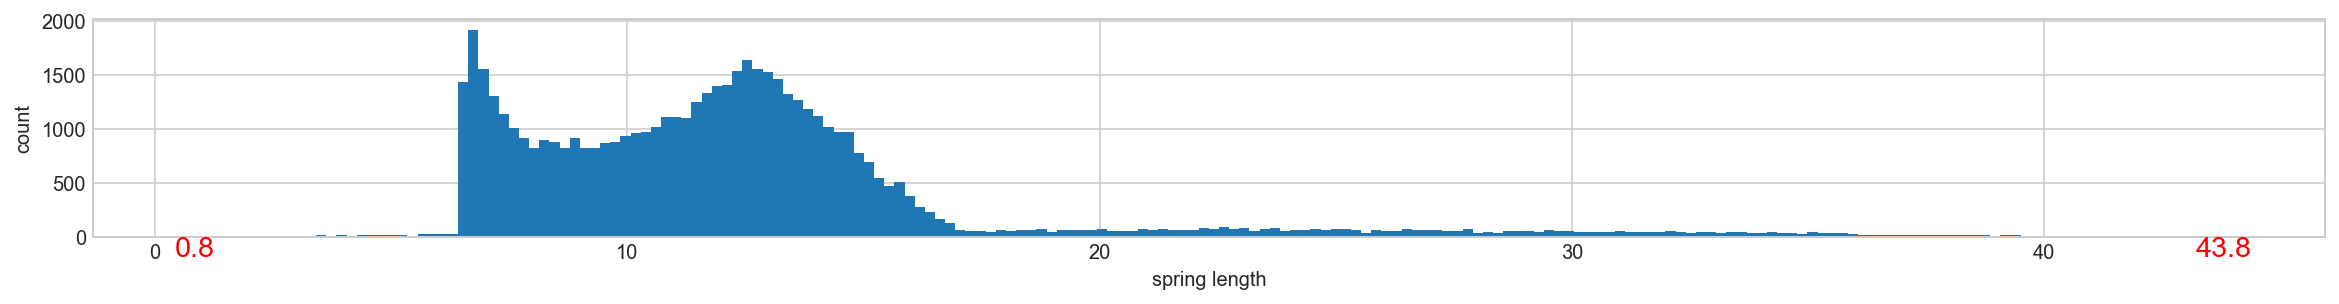

mean neighbors =43.2445456725006


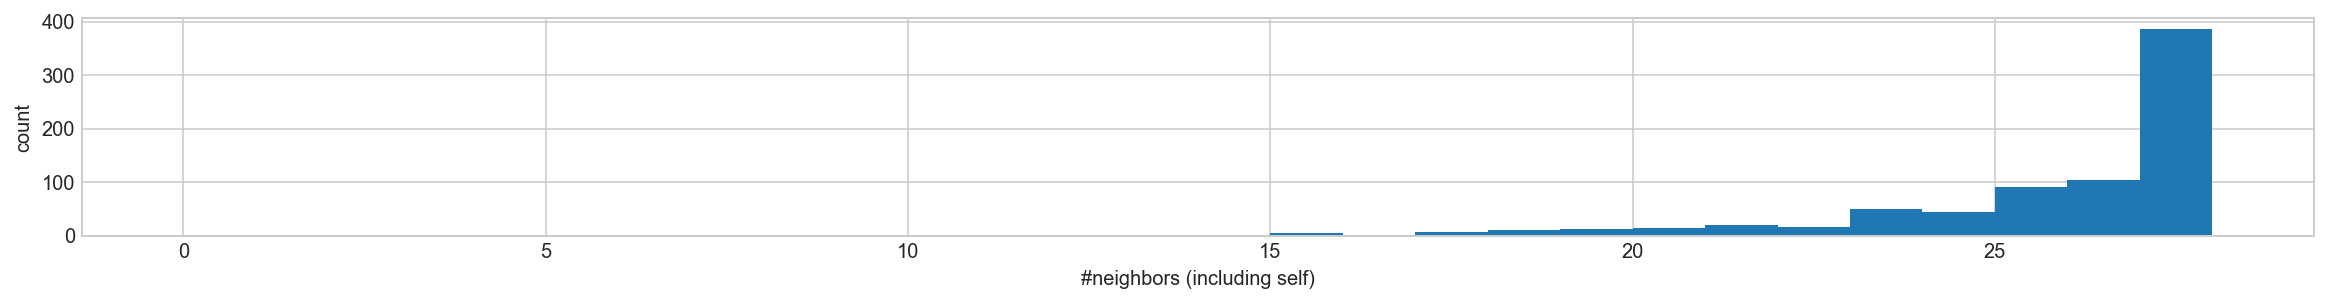

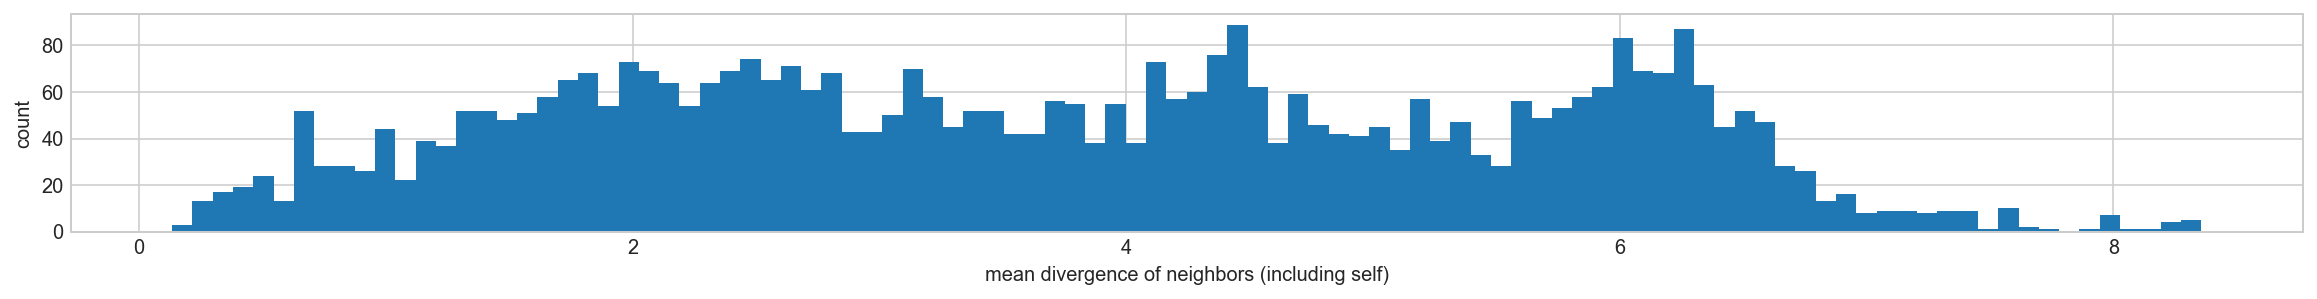

%surface points = 47%


In [355]:
print("#springs =%i"%(len(lines_all)))
print("#mass =%i"%(len(xyz_all)))

# check the distance of the springs
fig, ax = plt.subplots(figsize=(20,2))
hist,bin_edges,_ =ax.hist(np.linalg.norm(xyz_all[lines_all[:,0]] - xyz_all[lines_all[:,1]],axis=1),bins=200)
ax.text(bin_edges[0],0,f"{bin_edges[0]:.1f}",ha="center",va="top",fontsize="x-large",color='r')
ax.text(bin_edges[-1],0,f"{bin_edges[-1]:.1f}",ha="center",va="top",fontsize="x-large",color='r')
ax.set_xlabel("spring length")
ax.set_ylabel("count")
plt.show()

neighbor_counts = np.array([len(neighbor) for neighbor in neighbors])
print(f"mean neighbors ={np.mean(neighbor_counts)}")
fig, ax = plt.subplots(figsize=(20,2))
hist,bin_edges,patches =ax.hist(neighbor_counts,bins=28,range=(0,28))
ax.set_xlabel("#neighbors (including self)")
ax.set_ylabel("count")
# ax.text(surface_neighbor_threshold,0,f"{surface_neighbor_threshold}",ha="center",va="top",fontsize="x-large",color='r')
plt.show()



# average divergence of the neighbors from a point
average_divergence = np.linalg.norm([xyz_all[n].mean(axis=0)-xyz_all[n[0]] for n in neighbors],axis=1)
fig, ax = plt.subplots(figsize=(20,2))
hist,bin_edges,patches =ax.hist(average_divergence,bins=100)
ax.set_xlabel("mean divergence of neighbors (including self)")
ax.set_ylabel("count")
plt.show()

# is_suface is boolean array to specify wether the point is near the surface, useful for applying contraints
surface_neighbor_threshold = int(max_nn*0.9)
is_suface = np.logical_or(average_divergence>0.6*radius_poisson,neighbor_counts<surface_neighbor_threshold)
is_suface[id_xyzs_edges[n_parts]:]=False # only body parts are considered
print(f"%surface points = {is_suface.sum()/len(is_suface)*100:.0f}%")

In [356]:
neighbor_counts.min()

3

In [357]:
colors_all_check = np.copy(colors_all)
colors_all_check[is_suface]=(1,0.1,0.1)
colors_all_check[~is_suface]=(0,0,0.1)

pcd_assembly.colors = o3d.utility.Vector3dVector(colors_all_check)

lsd_assembly.colors = o3d.utility.Vector3dVector((colors_all_check[lines_all[:,0]]+colors_all_check[lines_all[:,1]])/2)

In [358]:
# o3d.visualization.draw_geometries([pcd_assembly,lsd_assembly,coord_frame]+axes)
# o3d.visualization.draw_geometries([pcd_assembly,coord_frame]+axes)

o3d.visualization.draw_geometries([pcd_assembly])

# o3d.visualization.draw_geometries([pcd_assembly,lsd_assembly])

# o3d.visualization.draw_geometries([pcd_assembly,coord_frame]+axes)

# export assembly

In [359]:
xyz_all_trans = ApplyTransform(xyz_all, 
               np.array([[0,1,0],
                         [0,0,1],
                         [1,0,0]]).T)
min_bound = xyz_all_trans.min(axis=0)

# transoformed so that z is pointed up, scaled mm->m
xyz_all_trans = (xyz_all_trans + np.array([0,0,0-min_bound[-1]]))/1000

pcd_assembly = o3d.geometry.PointCloud()
pcd_assembly.points = o3d.utility.Vector3dVector(xyz_all_trans)
pcd_assembly.colors = o3d.utility.Vector3dVector(colors_all)
coord_frame_mm = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.06, origin=[0, 0, 0])
o3d.visualization.draw_geometries([pcd_assembly,coord_frame_mm])

data = [
    xyz_all_trans.tolist(),
    lines_all.tolist(),
    is_suface.tolist(),
    id_xyzs_edges.tolist(),
    id_lines_edges.tolist(),
    colors_all.tolist(),
    joints_list
]

In [360]:
xyz_all_trans.shape

(4171, 3)

In [361]:
print(xyz_all_trans.min(axis=0))
print(xyz_all_trans.max(axis=0))

[-0.12549175 -0.13219319  0.        ]
[0.19405678 0.13219319 0.0519996 ]


In [362]:
# https://stackoverflow.com/questions/43442194/how-do-i-read-and-write-with-msgpack
    
# Write msgpack file
with open('data.msgpack', 'wb') as outfile:
    msgpack.pack(data, outfile)

In [72]:
# Read msgpack file
with open('data.msgpack','rb') as data_file:
    # data_loaded = json.load(data_file)
    data_loaded = msgpack.unpack(data_file)

In [91]:
len(data_loaded[1])

68106

In [45]:
# x = b'\x01\x02'

# dt = np.dtype(np.uint16)
# dt = dt.newbyteorder('>')
# np.frombuffer(x,dtype=dt)